In [1]:
import json
from matplotlib import pyplot as plt
from collections import Counter
from data_processing import parse_example_file

Загрузим тестовые данные, в которых мы знаем правильные рассуждения и ответы, а также решения, полученные нами в ходе экспериментов.

In [2]:
test_data = parse_example_file("data/test.jsonl")

simple_cot_results = []
with open("results/results.jsonl", "r") as f:
    for line in f:
        simple_cot_results.append(json.loads(line))
ensemble_cot_results = []
with open("results/results_ensemble.jsonl", "r") as f:
    for line in f:
        ensemble_cot_results.append(json.loads(line))

Найдем верно решенные задачи для обычного CoT:

In [3]:
correct_answers_simple = []
for i, (pred, true) in enumerate(zip(simple_cot_results, test_data)):
    if pred["answer"] == true.answer:
        correct_answers_simple.append(i)
print(correct_answers_simple)
print(f"Solve rate: {len(correct_answers_simple) / 2}%")

[0, 16, 32, 42, 44, 55, 56, 79, 80, 83, 89, 105, 113, 130, 132, 136, 140, 152, 160, 167, 179, 180, 185, 190, 194]
Solve rate: 12.5%


И для ансамблированного:

In [4]:
correct_answers_ensemble = []
for i, (pred, true) in enumerate(zip(ensemble_cot_results, test_data)):
    if pred["answer"] == true.answer:
        correct_answers_ensemble.append(i)
print(correct_answers_ensemble)
print(f"Solve rate: {len(correct_answers_ensemble) / 2}%")

[0, 1, 3, 22, 40, 42, 49, 55, 56, 62, 69, 71, 76, 77, 79, 83, 93, 105, 112, 113, 114, 117, 120, 131, 134, 136, 140, 142, 152, 164, 166, 170, 176, 179, 180, 185, 194, 196]
Solve rate: 19.0%


Довольно ожидаемо, что ансамблированный CoT будет работать лучше, хотя есть уникальные задачи, которые были решены только через обычный CoT (и наоборот):

In [5]:
print(set(correct_answers_simple) - set(correct_answers_ensemble))
print(set(correct_answers_ensemble) - set(correct_answers_simple))

{32, 160, 130, 132, 167, 44, 16, 80, 89, 190}
{1, 3, 131, 134, 142, 22, 164, 166, 40, 170, 176, 49, 62, 196, 69, 71, 76, 77, 93, 112, 114, 117, 120}


Если почитать их решения, то особо уникальных закономерностей найти не получается. Поэтому лучше проанализируем отличия верно решенных задач от остальных.
Первое, что хочется проверить -- число шагов в решении, так как иногда видно, что ход правильный, но результат промежуточного вычисления выдан за ответ.
Удобно, что по нашему формату каждое рассуждение с новой строки.

In [6]:
def get_steps(a: str) -> int:
    return len(a.strip().split("\n"))


true_length = [get_steps(a.thought) + 1 for a in test_data]
simple_length = [get_steps(a["solution"]) + 1 for a in simple_cot_results]
ensemble_length = [get_steps(a["solution"]) + 1 for a in simple_cot_results]

Построим графики с разницей в числе шагов для правильных и неправильных ответов в простом CoT:

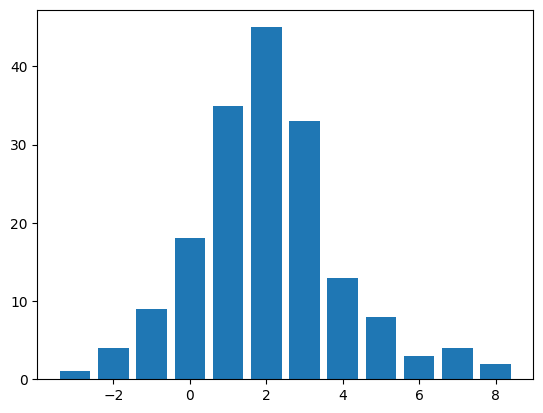

In [9]:
c = Counter([simple_length[i]-true_length[i] for i in range(len(simple_length)) if i not in correct_answers_simple])
plt.bar(list(c.keys()), list(c.values()))
plt.show()

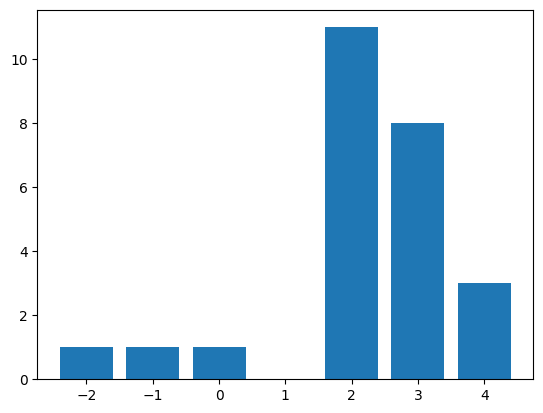

In [8]:
c = Counter([simple_length[i]-true_length[i] for i in range(len(simple_length)) if i in correct_answers_simple])
plt.bar(list(c.keys()), list(c.values()))
plt.show()

Неправильные рассуждения иногда сильно длиннее, потому вычисления зависли. Правильные обычно чуть длиннее оригинала, потому что каждый шаг расписывается отдельно (как и в prompt, поэтому результат логичен).
Теперь то же для ансамблированного CoT:

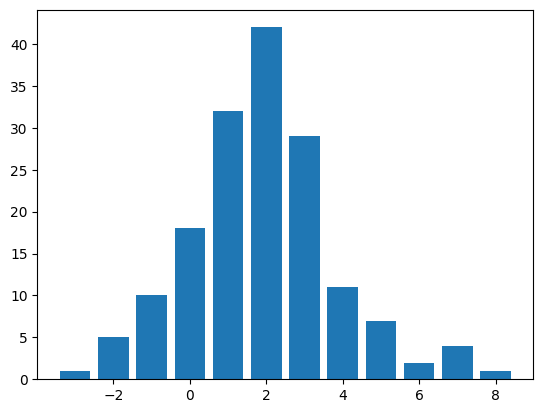

In [10]:
c = Counter([ensemble_length[i]-true_length[i] for i in range(len(ensemble_length)) if i not in correct_answers_ensemble])
plt.bar(list(c.keys()), list(c.values()))
plt.show()

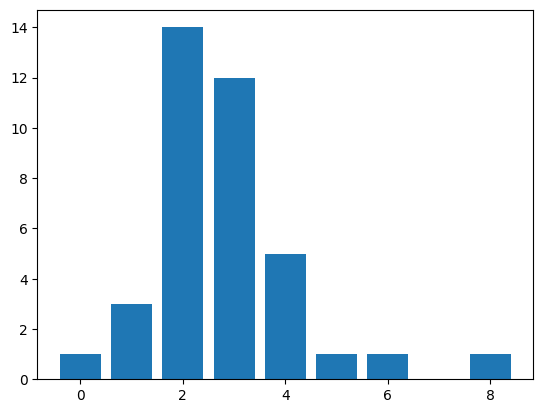

In [11]:
c = Counter([ensemble_length[i]-true_length[i] for i in range(len(ensemble_length)) if i in correct_answers_ensemble])
plt.bar(list(c.keys()), list(c.values()))
plt.show()

Здесь картина аналогичная, только ярче выражена особенность, что число шагов во всех правильных решениях не меньше, чем в оригинальных.

Очень интересно для ансамблированного CoT посмотреть на число вхождений ответа (из 40), с которого он признавался правильным:

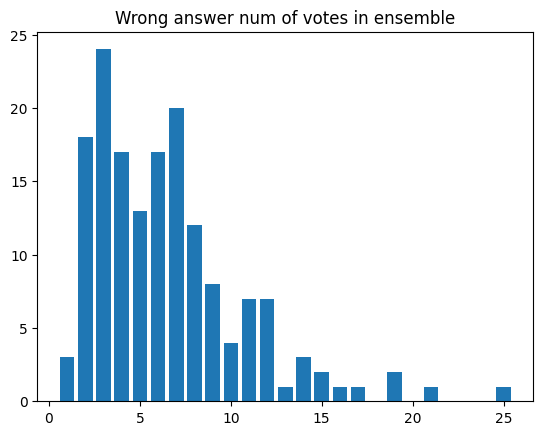

In [15]:
c = Counter([ensemble_cot_results[i]["num"] for i in range(len(ensemble_length)) if i not in correct_answers_ensemble])
plt.bar(list(c.keys()), list(c.values()))
plt.title("Wrong answer num of votes in ensemble")
plt.show()

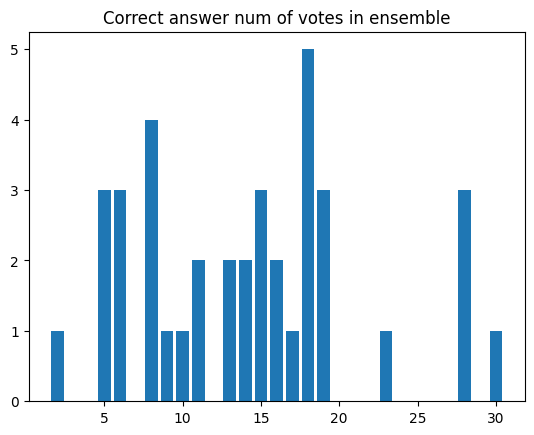

In [16]:
c = Counter([ensemble_cot_results[i]["num"] for i in range(len(ensemble_length)) if i in correct_answers_ensemble])
plt.bar(list(c.keys()), list(c.values()))
plt.title("Correct answer num of votes in ensemble")
plt.show()

Как мы видим, если ответ получил меньше 10 голосов, он скорее всего неправильный.
Из этого рождается следующая идея оптимизации:
1. Сгенерировать много размышлений, что должно занимать меньше времени, чем в наших экспериментах, потому что запросы можно обработать батчем
2. Если есть ответ, встретившийся не меньше, чем в 25% случаях (порог нужно уточнять, потому что 200 примеров не очень репрезентативны), то берем его
3. Иначе генерируем самое вероятное рассуждение обычным Chain-of-Thoughts и берем ответ из него.